feature_data shape: (1000, 6)
labels shape: (1000,)
Epoch 1, Average Task Loss: nan
Epoch 2, Average Task Loss: nan
Epoch 3, Average Task Loss: nan
Epoch 4, Average Task Loss: nan
Epoch 5, Average Task Loss: nan
Epoch 6, Average Task Loss: nan
Epoch 7, Average Task Loss: nan
Epoch 8, Average Task Loss: nan
Epoch 9, Average Task Loss: nan
Epoch 10, Average Task Loss: nan
1/1 [==============================] - 0s 351ms/step
Predicted Congestion Dissipation Time: [[-0.29492468]]


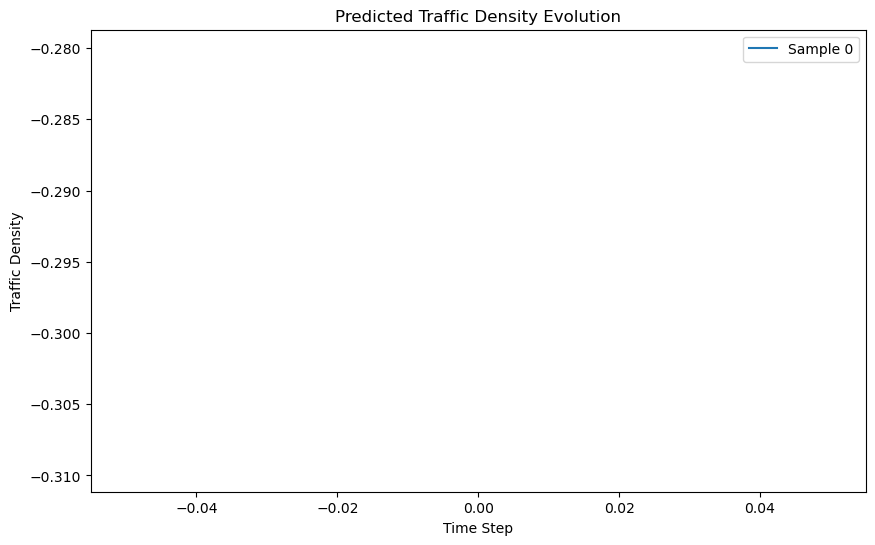

In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Dense, Conv1D, MaxPooling1D, GRU, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt  # Add this line to import the plt module

# 步骤1：载入配置文件csv
#device_mapping = pd.read_csv("device_mapping.csv")
# algorithm_params = pd.read_csv("algorithm_params.csv")
# event_data_df = pd.read_csv("event_data.csv")
# # 读取特征数据、属性特征和标签数据
# feature_data = pd.read_csv("feature_data.csv").values
# labels = pd.read_csv("labels.csv").values
# attribute_features = pd.read_csv("attribute_features.csv").values
device_mapping = {
    'Highway A': 0,  # 假设设备ID为 'Highway A' 对应数据索引为 0
    'Road B': 1,     # 假设设备ID为 'Road B' 对应数据索引为 1
    'City X': 2      # 假设设备ID为 'City X' 对应数据索引为 2
}

# 现在可以使用上述代码片段运行代码
# ...

# # 步骤2：获取事件信息
# event_occurred = True  # 是否有事件发生，根据实际情况设置
# event_info = {}  # 事件相关信息，根据实际情况填充
# 步骤2：获取事件信息
event_occurred = True  # 是否有事件发生，根据实际情况设置
def extract_data(device_mapping, event_info):
    # 假设您的设备映射是一个字典，包含设备ID和相应的数据索引
    device_id = event_info['event_data']['location']  # 假设事件数据中有设备ID
    data_index = device_mapping.get(device_id, None)
    
    if data_index is not None:
        event_data = feature_data[data_index]  # 假设 feature_data 是您的特征数据
        return event_data
    else:
        return None  # 无法找到对应设备的数据
# 随机生成示例事件类型和事件数据
if event_occurred:
    event_types = ['accident', 'road_closure', 'weather_alert']
    random_event_type = np.random.choice(event_types)
    
    event_data = {}
if random_event_type == 'accident':
    event_data['location'] = 'Highway A'
    event_data['severity'] = 'major'
elif random_event_type == 'road_closure':
    event_data['location'] = 'Road B'  # 添加'location'键
    event_data['closure_type'] = 'construction'
elif random_event_type == 'weather_alert':
    event_data['location'] = 'City X'  # 添加'location'键
    event_data['alert_type'] = 'heavy_rain'
    event_data['affected_area'] = 'City X'
    event_info = {
        'event_type': random_event_type,
        'event_data': event_data
    }
else:
    event_info = {
        'event_type': None,
        'event_data': None
    }

# 现在，all_event_info 列表中包含了所有事件信息
# 您可以根据需要遍历列表，对每个事件信息进行预测等操作
for event_info in all_event_info:
    event_type = event_info['event_type']
    event_data = event_info['event_data']
    # 在这里进行预测等操作
# 示例：随机生成特征数据和属性特征
def generate_random_data(num_samples, num_features):
    # 随机生成特征数据（速度、流量、密度等）
    random_speed = np.random.uniform(20, 120, num_samples)  # 20-120之间的随机速度
    random_inflow = np.random.randint(100, 1000, num_samples)  # 100-1000之间的随机流量
    random_outflow = np.random.randint(100, 1000, num_samples)
    random_density = np.random.uniform(0.1, 1.0, num_samples)  # 0.1-1.0之间的随机密度
    
    # 随机生成属性特征（封闭车道数、天气情况等）
    random_num_closed_lanes = np.random.randint(0, 3, num_samples)  # 0-3之间的随机封闭车道数
    random_weather_condition = np.random.randint(0, 3, num_samples)  # 0-2之间的随机天气情况
    
    # 构建特征矩阵
    feature_matrix = np.column_stack((random_speed, random_inflow, random_outflow, random_density,
                                      random_num_closed_lanes, random_weather_condition))
    
    # 随机生成标签（拥堵消散时间）
    random_congestion_time = np.random.randint(5, 120, num_samples)  # 5-120之间的随机拥堵消散时间
    
    return feature_matrix, random_congestion_time

# 生成随机数据
num_samples = 1000  # 数据样本数
num_features = 6  # 特征数量
feature_data, labels = generate_random_data(num_samples, num_features)
def extract_subtask_data(dataset, start_idx, end_idx):
    subtask_feature_data = dataset[start_idx:end_idx, :]
    subtask_labels = labels[start_idx:end_idx]  # 假设 labels 是拥堵消散时间的标签
    return subtask_feature_data, subtask_labels

# 步骤4：使用随机生成的数据进行训练和测试
x_train, x_test, y_train, y_test = train_test_split(feature_data, labels, test_size=0.2, random_state=42)
print("feature_data shape:", feature_data.shape)
print("labels shape:", labels.shape)

# 调整输入数据维度
sequence_length = 1
x_train_cnn = np.reshape(x_train, (x_train.shape[0], sequence_length, num_features))
x_test_cnn = np.reshape(x_test, (x_test.shape[0], sequence_length, num_features))

# 定义LWR模型
def lwr_model(rho, v_max, rho_max):
    flux = rho * v_max * (1 - rho / rho_max)
    rho_next = np.zeros_like(rho)
    for i in range(1, len(rho)):
        rho_next[i] = rho[i] - (flux[i] - flux[i - 1])
    return rho_next

def build_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    cnn_layer = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
    maxpool_layer = MaxPooling1D(pool_size=2, padding='same')(cnn_layer)

    gru_layer = GRU(32)(maxpool_layer)
    
    # 添加注意力机制
    attention_probs = Attention()([gru_layer, gru_layer])
    attention_mul = Concatenate()([gru_layer, attention_probs])
    
    # 密度特征输入
    rho_input = Input(shape=(1,))  # 一个密度特征
    dense_rho = Dense(16, activation='relu')(rho_input)
    
    # 拼接时空特征、属性特征和密度特征
    concatenated = Concatenate()([attention_mul, dense_rho])
    
    output_layer = Dense(num_classes, activation='linear')(concatenated)
    
    model = Model(inputs=[input_layer, rho_input], outputs=output_layer)
    return model

#  步骤5：构建模型结构
input_shape = (sequence_length, num_features)
num_classes = 1  # 回归问题，预测时间
model = build_model(input_shape, num_classes)

# 步骤6：设计损失函数
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate), loss=MeanSquaredError())

# 步骤7：采用MAML方法进行分任务学习
def maml_train(model, train_data, num_epochs, learning_rate):
    meta_optimizer = Adam(learning_rate=learning_rate)
    for epoch in range(num_epochs):
        task_losses_epoch = []
        for task_data in train_data:
            x_train, y_train = task_data
            with tf.GradientTape() as tape:
                predictions = model(x_train)
                task_loss = tf.reduce_mean(tf.square(predictions - y_train))
            gradients = tape.gradient(task_loss, model.trainable_variables)
            meta_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            task_losses_epoch.append(task_loss)
        print(f"Epoch {epoch + 1}, Average Task Loss: {np.mean(task_losses_epoch)}")

# 步骤8：分割数据集为Meta-Train和Meta-Test
# 根据异常事件类型划分数据集为不同的子任务数据，每个子任务包含相应的特征数据和标签
# 在这里您需要根据您的数据定义不同的子任务划分方式
num_samples = len(feature_data)
num_subtasks = 4
subtask_data_size = num_samples // num_subtasks  # 计算每个子任务的数据大小

train_data = []

for subtask_idx in range(num_subtasks):
    # 根据子任务的特定事件类型，从数据集中提取相应的数据
    subtask_start_idx = subtask_idx * subtask_data_size  # 根据实际情况计算起始索引
    subtask_end_idx = (subtask_idx + 1) * subtask_data_size  # 根据实际情况计算结束索引
    subtask_feature_data, subtask_labels = extract_subtask_data(feature_data, subtask_start_idx, subtask_end_idx)
    # 将子任务数据添加到 train_data 列表中
    train_data.append((subtask_feature_data, subtask_labels))
# 步骤9：使用MAML训练不同子任务
train_data = []  # 存放不同子任务的数据
num_epochs_maml = 10  # MAML迭代次数
learning_rate_maml = 0.001  # MAML学习率
maml_train(model, train_data, num_epochs_maml, learning_rate_maml)

# 步骤10：计算测试损失
def calculate_test_loss(model, test_data):
    test_losses = []
    for x_test, y_test in test_data:
        predictions = model(x_test)
        test_loss = np.mean(np.square(predictions - y_test))
        test_losses.append(test_loss)
    return np.mean(test_losses)

# 步骤11：在新任务上进行预测
def predict_new_task(model, new_task_data, rho):
    # 调整输入数据维度以匹配模型的输入层
    new_task_data = np.reshape(new_task_data, (1, sequence_length, num_features))  # 修改此处
    rho = np.array([[rho]])  # 将密度值包装成一个数组以匹配密度特征的形状
    predictions = model.predict([new_task_data, rho])
    return predictions
if event_occurred:
    event_data = extract_data(device_mapping, event_info)
    density_value = 0.9  # 使用实际的 event_data 中的密度值
    predicted_time = predict_new_task(model, event_data, density_value)
    print(f"Predicted Congestion Dissipation Time: {predicted_time}")
    # 可视化预测结果
plt.figure(figsize=(10, 6))
for i in range(len(predicted_time)):
    plt.plot(predicted_time[i], label=f"Sample {i}")
plt.xlabel("Time Step")
plt.ylabel("Traffic Density")
plt.title("Predicted Traffic Density Evolution")
plt.legend()
plt.show()